# Practica 2: Convolutional Neural Network (CNN)
*Elaborado por: Luis Fernando Becerra, BEDA Aprendizaje de Máquinas 2024-1S *

Esta guia muestra el entrenamiento de una simple Red Neuronal Convolucional (CNN) para clasificar imágenes. Vamos a utilizar la base de datos CIFAR. Utilizaremos los modelos secuenciales de keras para la implementación de la red.

### Importar librerias

In [3]:
import  matplotlib.pyplot as plt

In [4]:
##

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import datasets


### Descargar y preparar el conjunto de datos CIFAR10


El conjunto de datos CIFAR10 contiene 60.000 imágenes en color en 10 clases, con 6.000 imágenes en cada clase. El conjunto de datos se divide en 50.000 imágenes de entrenamiento y 10.000 imágenes de prueba. Las clases se excluyen mutuamente y no hay solapamiento entre ellas. El dataset se encuentra disponible en varios repositorios, vamos a trabjar con los datos cargados en la libreria keras.

In [5]:
#Cargar datos entrenamiento y prueba

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

Un paso importante de preprocesamiento de los datos a usar con redes profundas es la normalización. Este paso ayuda a los optimizadores a converger más rapido, sin que ninguna de las caracteristicas tenga mayor peso en la selección de la dirección de la convergencia. En el caso de las imágenes en escala de grises y RGB, la normalización es muy sencilla. Usualmente las imágenes en escala de grises (1 sola capa) o RGB (3 capas correspondientes a los colores rojo, verde y azul) se encuentran en formato UINT8, es decir, que cada prixel se representa por valores de 0 a 255. Por lo tanto, para la normalización de los datos solo requerimos dividir por 255.

Nota: cuando se trabajan con otros tipos de imágenes (por ejemplo satelitales) es importante revisar el formato de los datos, o realizar una normalización MIN-MAX.

In [6]:
#Normalización de los datos
train_images,test_images = train_images/255.0,test_images/255.0

### Verificar los datos

Para verificar el contenido de la base de datos, vamos a grraficar las primeras 25 muestras del conjunto de entrenamiento con su respectiva etiqueta.

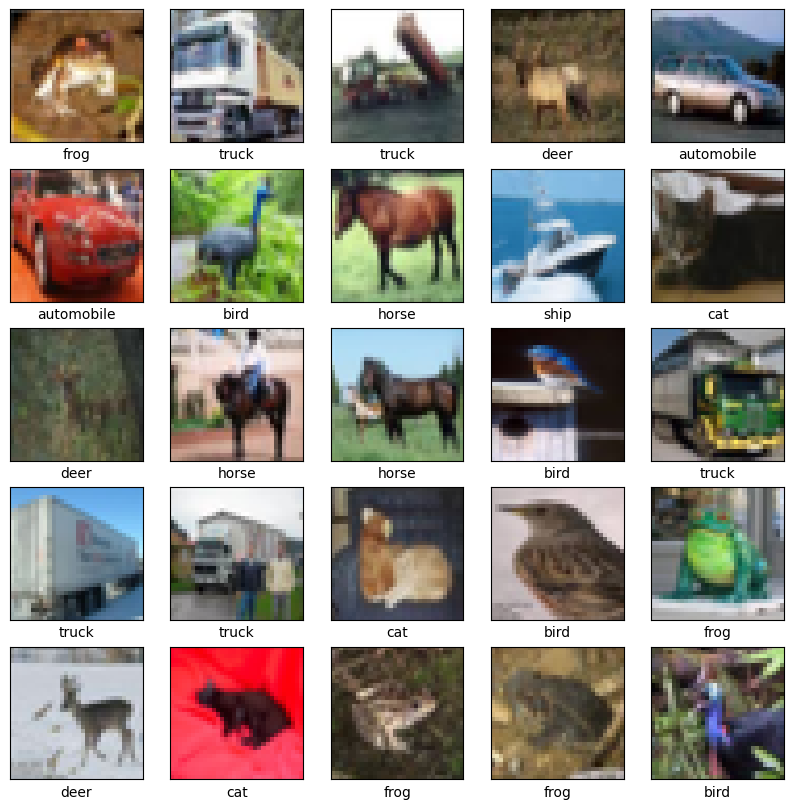

In [7]:
#Visualización de los datos
#Nombre de las clases
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
#Visualización de las imagenes
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

##  Crear la arquitectura

Vamos a definir una arquitectura común usando una pila de capas convolucionales (Conv2D) y de pooling (MaxPooling2D).

Como entrada, una CNN toma tensores de la forma pixeles_por_fila X pixels_por_columna X no_canales (image_height, image_width, color_channels). Las imágenes en escala de grises solo cuentan con 1 canal, en cambio las imágenes que capturamos con nuestros celulares o camaras convencionales usualmente tienen 3 canales correspondientes al RGB.

En nuestro ejemplo la dimesión de los datos es de 32x32x3. Con estas dimensiones configuramos la capa de entrada.

In [8]:
#Definición del modelo
model = Sequential()
#Capa convolucional y pooling
model.add(Conv2D(32,(3,3), activation='relu',input_shape=(32,32,3)))
model.add(MaxPooling2D(2,2))
#Capa convolucional y pooling
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
#Capa convolucional
model.add(Conv2D(64,(3,3),activation='relu'))

c:\Users\jupja\OneDrive\Escritorio\IA\Practica 2\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Recordemos que con el metodo summary() podemos revisar la arquitectura de nuestra red, así como ver el número de parámetros que debemos entrenar.

In [9]:
##
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

En el resumen del modelo deberias ver que la salida de cada capa Conv2D y MaxPooling2D es un tensor 3D de forma (altura, anchura, canales). Las dimensiones de anchura y altura tienden a reducirse a medida que se profundiza en la red, esto por el efecto del pooling. El número de canales de salida para cada capa Conv2D se controla mediante el primer argumento (por ejemplo, 32 o 64). Normalmente, a medida que la anchura y la altura se reducen, puedes permitirte (computacionalmente) añadir más canales de salida en cada capa Conv2D.

Para completar el modelo, vamos a introducir el último tensor de salida (de la forma (4, 4, 64)) en una o más capas Densas para realizar la clasificación. Las capas densas toman vectores como entrada (que son 1D), mientras que la salida actual es un tensor 3D. Por lo cual, es nesario en primer lugar "aplanar" el tensor (Flatten()), y a continuación, añadir una o más capas densas. CIFAR tiene 10 clases de salida, por lo que se utiliza una capa Densa final con 10 salidas.

Recuerda: El número de capas convolucionales y densas, así como el número de filtros convolucionales, tipo de pooling, número de neuronas ocultas, funciones de activación, son parametros que debe determinar el ingeniero ML.

In [10]:
#Capas densas
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(10))

Visualiza la arquitectura completa de tu modelo:

In [11]:
##
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

El resumen de la red deberia mostar que las salidas (4, 4, 64) se aplanaron en vectores de forma (1024) antes de pasar por dos capas densas.

### Entrenamiento del modelo

Para el entrenamiento, debemos definir:


*   Optimizador: Keras soporta diferentes tipos de optimizadores, en el [link](https://keras.io/api/optimizers/) puedes encontrar la lista completa. Para nuestro ejemplo vamos usar el optimizador 'adam'. Este es una implementación del gradiente descendiente estocatico que utiliza una estimación adaptiva. Por defecto, el paso de aprendizaje para este optimizador es del 0.001.
*   Función de perdida: El proposito de la función de perdida es calcular la calidad del modelo mientras se realiza la optimización durante el entrenamiento. La lista completa se puede encontrar en este [link](https://keras.io/api/optimizers/). Esta debe seleccionar de acuerdo con la tarea (clasificación o regresión). En este ejemplo vamos a usar la entropia cruzada categorica esparcida; la cual se puede usar cuando esperamos que la salida sea una categoria y además tenemos mas de dos clases o etiquetas.
*   Metrica de evaluación: Es una función que permite evaluar el desempeño del modelo. Esta no se utiliza como parte del proceso de entrenamiento. Existen diferentes tipos de metrica, y se puede usar cualquier función de perdida como metrica. Sin embargo, en nuestro vamos a utilizar el accuracy. Una lista completa de metricas disponibles en keras puede ser consultado en este [link](https://keras.io/api/metrics/).
*texto en cursiva*

In [12]:
#Función de perdida
from tensorflow.keras.losses import SparseCategoricalCrossentropy
#Parametros para entrenamiento
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#Entrenamiento
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - accuracy: 0.3422 - loss: 1.7797 - val_accuracy: 0.5407 - val_loss: 1.2959
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.5677 - loss: 1.2245 - val_accuracy: 0.6068 - val_loss: 1.1125
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.6284 - loss: 1.0521 - val_accuracy: 0.6228 - val_loss: 1.0649
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step - accuracy: 0.6665 - loss: 0.9473 - val_accuracy: 0.6513 - val_loss: 1.0177
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - accuracy: 0.6968 - loss: 0.8592 - val_accuracy: 0.6891 - val_loss: 0.8929
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.7192 - loss: 0.8032 - val_accuracy: 0.6964 - val_loss: 0.8866
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.7394 - loss: 0.7436 - val_accuracy: 0.6982 - val_loss: 0.8884
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.7577 -

### Evalúe el modelo

313/313 - 2s - 6ms/step - accuracy: 0.7108 - loss: 0.8605


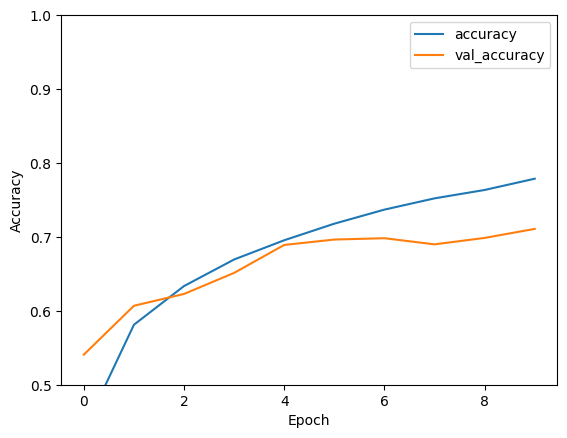

In [13]:
#Visualización de resultados de entrenamiento y validación
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend()

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [14]:
print(test_acc)

0.7107999920845032


Su sencilla CNN deberia haber logrado una precisión en las pruebas superior al 70%. ¡No está mal para unas pocas líneas de código! Para otro estilo de CNN, echa un vistazo al ejemplo [TensorFlow 2 quickstart for experts](https://www.tensorflow.org/tutorials/quickstart/advanced) que utiliza la API de subclases de Keras y `tf.GradientTape`.

In [15]:
#Funciones de sklearn para metricas de desempeño
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
import numpy as np

In [17]:
#Predicción
pred_labels = model.predict(test_images)
y = np.argmax(pred_labels,axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1000
           1       0.84      0.83      0.84      1000
           2       0.59      0.60      0.59      1000
           3       0.58      0.46      0.51      1000
           4       0.66      0.70      0.68      1000
           5       0.56      0.68      0.61      1000
           6       0.79      0.78      0.78      1000
           7       0.75      0.72      0.74      1000
           8       0.81      0.83      0.82      1000
           9       0.81      0.77      0.79      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000

kappa: 0.6786666666666666


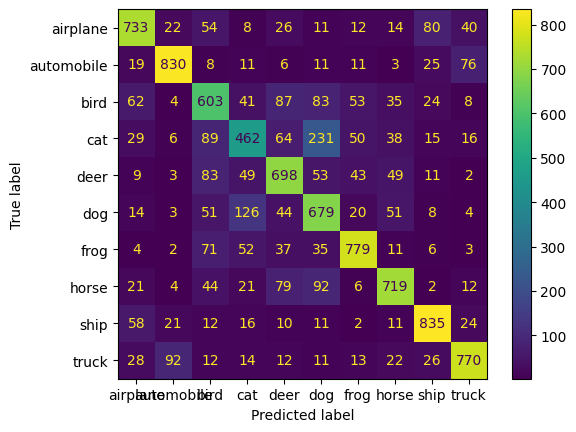

In [18]:
# Métricas de desempeño
cm_cnn = confusion_matrix(test_labels, y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=class_names)
disp.plot()
print(classification_report(test_labels, y))
print("kappa: " + str(cohen_kappa_score(test_labels, y)))

# ¡Gran trabajo!